In [1]:
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
from scipy.spatial.distance import euclidean

In [2]:
# !pip install ortools

  Using cached ortools-9.11.4210-cp311-cp311-macosx_11_0_arm64.whl.metadata (3.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached protobuf-5.26.1-cp37-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached immutabledict-4.2.1-py3-none-any.whl.metadata (3.5 kB)
Using cached ortools-9.11.4210-cp311-cp311-macosx_11_0_arm64.whl (20.7 MB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached immutabledict-4.2.1-py3-none-any.whl (4.7 kB)
Using cached protobuf-5.26.1-cp37-abi3-macosx_10_9_universal2.whl (404 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires protobuf<5,>=3.20, but you have protobuf 5.26.1 which is incompati

In [88]:
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
from scipy.spatial.distance import euclidean

def generate_synthetic_data():
    """Generates synthetic data where Y_actual and Y_predicted are correlated."""
    np.random.seed(42)
    
    # Define month distribution and observation counts
    months = ["2022-01", "2022-02", "2022-03", "2022-04", "2022-05"]
    obs_per_month = [2000, 5000, 3000, 4000, 2500]  # Variable number of observations per month
    
    data = []
    for month, obs in zip(months, obs_per_month):
        Y_actual = np.random.uniform(0.3, 0.8, obs)
        noise = np.random.normal(0.05, 0.2, obs)
        Y_predicted = np.clip(Y_actual + noise, 0, 1)
        for i in range(obs):
            data.append([
                month,        # Month column
                Y_actual[i],  # Y_actual
                Y_predicted[i],  # Y_predicted
                np.random.rand(),  # ts1
                np.random.rand(),  # ts2
                np.random.rand()   # ts3
            ])
    df = pd.DataFrame(data, columns=["month", "Y_actual", "Y_predicted", "ts1", "ts2", "ts3"])
    return df

def pre_bin_predictions(df, num_bins=10):
    """
    Perform equal-sized binning using quantiles (pd.qcut) on Y_predicted.
    (Pre-binning remains unchanged.)
    """
    df["bin"] = pd.qcut(df["Y_predicted"], q=num_bins, labels=False, duplicates='drop')
    return df

def compute_euclidean_distance_matrix(df):
    """
    Compute Euclidean distance matrix between pre-bins based on the mean of Y_predicted.
    """
    unique_bins = sorted(df["bin"].unique())
    n_bins = len(unique_bins)
    distance_matrix = np.zeros((n_bins, n_bins))
    for i in range(n_bins):
        for j in range(i, n_bins):
            mean_i = df[df["bin"] == unique_bins[i]]["Y_predicted"].mean()
            mean_j = df[df["bin"] == unique_bins[j]]["Y_predicted"].mean()
            distance_matrix[i, j] = distance_matrix[j, i] = euclidean([mean_i], [mean_j])
    return distance_matrix, unique_bins

def distance_matrix_local_neighbors(df, month_col="month"):
    """
    Build the custom distance matrix D so that:
      • D[i,i] : distance(s) between single bin i and its neighbour bins
      • D[i,j] (i>j): distance(s) between merged group j…i and exterior neighbours
    Returns
    -------
    D            : n_bins × n_bins numpy array (lower-triangle filled)
    unique_bins  : ordered list of bin labels
    """
    # ------------------------------------------------------------
    # 1.  Pre-compute single-bin time-series vectors and counts
    # ------------------------------------------------------------
    unique_bins = sorted(df["bin"].unique())  # [0,1,2,…,n-1]
    months      = sorted(df[month_col].unique())
    n_bins      = len(unique_bins)

    vec   = {}          # bin -> monthly-mean vector
    count = {}          # bin -> #records (needed for weighted merge)

    for b in unique_bins:
        sub = df[df["bin"] == b]
        v   = (sub.groupby(month_col)["Y_predicted"]
                    .mean()
                    .reindex(months)
                    .fillna(sub["Y_predicted"].mean())
                    .values)
        vec[b]   = v
        count[b] = len(sub)

    # ------------------------------------------------------------
    # 2.  Helper to build the merged vector G(j,i)
    # ------------------------------------------------------------
    def merged_vector(j, i):
        """Weighted mean vector of bins j…i (inclusive)."""
        total_cnt = sum(count[b] for b in range(j, i+1))
        wvec = sum(vec[b] * count[b] for b in range(j, i+1)) / total_cnt
        return wvec

    # ------------------------------------------------------------
    # 3.  Fill the matrix
    # ------------------------------------------------------------
    D = np.zeros((n_bins, n_bins))

    # Diagonal entries
    for k in range(n_bins):
        # neighbours: left (k-1) and/or right (k+1)
        if k > 0:
            D[k, k] += euclidean(vec[k], vec[k-1])
        if k < n_bins - 1:
            D[k, k] += euclidean(vec[k], vec[k+1])

    # Lower triangle: merged ranges
    for j in range(n_bins):          # start index
        merged_vec   = vec[j].copy()
        merged_cnt   = count[j]

        for i in range(j+1, n_bins): # end index (i>j)
            # incrementally extend the merge with bin i
            next_cnt   = count[i]
            merged_vec = (merged_vec * merged_cnt + vec[i] * next_cnt) / (merged_cnt + next_cnt)
            merged_cnt = merged_cnt + next_cnt

            # distance to exterior neighbours
            dist_sum = 0.0
            if j > 0:                 # left neighbour exists
                dist_sum += euclidean(merged_vec, vec[j-1])
            if i < n_bins - 1:        # right neighbour exists
                dist_sum += euclidean(merged_vec, vec[i+1])

            D[i, j] = dist_sum

    return D, unique_bins



def optimize_binning(distance_matrix, bin_percents,
                     min_bin_pct=0.10, min_bins=3, max_bins=6):
    """
    distance_matrix[i,j] (i >= j) must hold the score for the *whole* merged
    range j…i.  We convert it to an incremental (delta) table ∆ so that ranges
    are not double-counted, exactly like optbinning does for IV.
    """
    n = distance_matrix.shape[0]
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # ------------------------------------------------------------------ #
    # 1.  Decision variables  X[i,j]   (lower triangle: j ≤ i)
    # ------------------------------------------------------------------ #
    X = {(i, j): solver.BoolVar(f'X[{i},{j}]')
         for i in range(n)
         for j in range(i + 1)}          # j = 0 … i

    # ------------------------------------------------------------------ #
    # 2.  Build the *delta* matrix  Δ[i,j]  (incremental reward)
    #     Δ[i,j] = distance(j…i) − distance(j…i-1)
    # ------------------------------------------------------------------ #
    Delta = np.zeros_like(distance_matrix)

    for j in range(n):
        Delta[j, j] = distance_matrix[j, j]           # single-bin term
        for i in range(j + 1, n):
            Delta[i, j] = distance_matrix[i, j] - distance_matrix[i - 1, j]

    # ------------------------------------------------------------------ #
    # 3.  Objective:  Maximise   Σ Δ[i,j] · X[i,j]
    # ------------------------------------------------------------------ #
    objective = solver.Objective()
    for i in range(n):
        for j in range(i + 1):
            if Delta[i, j] != 0:                      # skip harmless zeros
                objective.SetCoefficient(X[i, j], float(Delta[i, j]))
    objective.SetMaximization()

    # ------------------------------------------------------------------ #
    # 4.  Constraints  (unchanged from your version)
    # ------------------------------------------------------------------ #
    # 4-A  Each pre-bin assigned exactly once
    for j in range(n):
        solver.Add(sum(X[i, j] for i in range(j, n)) == 1)

    # 4-B  Continuity (no gaps)
    for i in range(n):
        for j in range(i):
            solver.Add(X[i, j] <= X[i, j + 1])

    # 4-C  Number of final bins
    solver.Add(sum(X[i, i] for i in range(n)) >= min_bins)
    solver.Add(sum(X[i, i] for i in range(n)) <= max_bins)

    # 4-D  Minimum % size per final bin
    for i in range(n):
        solver.Add(sum(bin_percents[j] * X[i, j] for j in range(i + 1))
                   >= min_bin_pct * X[i, i])

    # ------------------------------------------------------------------ #
    # 5.  Solve
    # ------------------------------------------------------------------ #
    status = solver.Solve()
    if status not in (pywraplp.Solver.OPTIMAL, pywraplp.Solver.FEASIBLE):
        print("❌ No solution."); return None
    print("✅ Status:", "Optimal" if status==pywraplp.Solver.OPTIMAL else "Feasible",
          " Obj=", solver.Objective().Value())

    # ------------------------------------------------------------------ #
    # 6.  Extract merged bins
    # ------------------------------------------------------------------ #
    merged = {}
    for i in range(n):
        for j in range(i + 1):
            if X[i, j].solution_value() > 0.5:
                merged.setdefault(i, []).append(j)
    return merged


def apply_optimal_bins(df, bin_mapping):
    """
    Map the original pre-bins to their corresponding final (optimized) bins.
    """
    bin_map = {old_bin: new_bin for new_bin, old_bins in bin_mapping.items() for old_bin in old_bins}
    df["optimized_bin"] = df["bin"].map(bin_map)
    return df

def aggregate_by_month(df):
    """
    Aggregate the dataset by month and optimized bin.
    """
    agg_df = df.groupby(["month", "optimized_bin"]).agg({
        "Y_actual": ["mean", "count"],
        "Y_predicted": ["mean"]
    }).reset_index()
    agg_df.columns = ["month", "optimized_bin", "Y_actual_mean", "count", "Y_predicted_mean"]
    return agg_df

def compute_bin_min_percentage(df):
    """Compute the minimum percentage of total observations for each bin across all months."""
    # Compute bin counts by month
    bin_counts_by_month = df.groupby("month")["bin"].value_counts().unstack().fillna(0)
    # print(bin_counts_by_month)
    # Convert counts to percentages
    bin_percentages = bin_counts_by_month.div(bin_counts_by_month.sum(axis=1), axis=0)
    
    # Get the minimum percentage for each bin across all months
    min_bin_percentages = bin_percentages.min(axis=0).to_numpy()
    
    return min_bin_percentages


# Main Execution

# Step 1: Generate synthetic data
df = generate_synthetic_data()

# Step 2: Pre-bin Y_predicted using quantiles (we do not change this step)
df = pre_bin_predictions(df, num_bins=10)

# Step 3: Compute Euclidean distance matrix based on Y_predicted only
distance_matrix, unique_bins = distance_matrix_local_neighbors(df)

# Step 4: Compute pre-bin counts (as an array) and total observations.
# We assume the pre-bin labels are sorted as in unique_bins.
bin_counts_series = df["bin"].value_counts().sort_index()
bin_counts = [bin_counts_series.get(b, 0) for b in unique_bins]
total_obs = len(df)
print("Pre-bin counts:", bin_counts)
print("Total observations:", total_obs)
bin_percents = compute_bin_min_percentage(df)

# Step 5: Run the optimization with the minimum bin percentage constraint.
# Here, min_bin_pct is defined by the user (e.g., 10%).
min_bin_pct = 0.10  
optimal_bins = optimize_binning(distance_matrix, bin_percents, min_bin_pct=min_bin_pct, min_bins=4, max_bins=6)

# Step 6: Apply the optimal bin mapping back to the dataset.
df = apply_optimal_bins(df, optimal_bins)

# Step 7: Aggregate results by month and optimized bin.
aggregated_df = aggregate_by_month(df)

# Display results.
print("\nOptimized binning structure:", optimal_bins)
print("\nAggregated data by month and optimized bin:")
print(aggregated_df)


Pre-bin counts: [1650, 1650, 1650, 1650, 1650, 1650, 1650, 1650, 1650, 1650]
Total observations: 16500
✅ Status: Optimal  Obj= 2.1863095508612993

Optimized binning structure: {1: [0, 1], 3: [2, 3], 5: [4, 5], 7: [6, 7], 9: [8, 9]}

Aggregated data by month and optimized bin:
      month  optimized_bin  Y_actual_mean  count  Y_predicted_mean
0   2022-01              1       0.424802    405          0.253547
1   2022-01              3       0.490070    387          0.464803
2   2022-01              5       0.553941    393          0.599194
3   2022-01              7       0.602717    403          0.734115
4   2022-01              9       0.670731    412          0.921570
5   2022-02              1       0.433667    978          0.262840
6   2022-02              3       0.492673   1003          0.466962
7   2022-02              5       0.552910    997          0.604334
8   2022-02              7       0.599776   1034          0.735800
9   2022-02              9       0.669942    988     

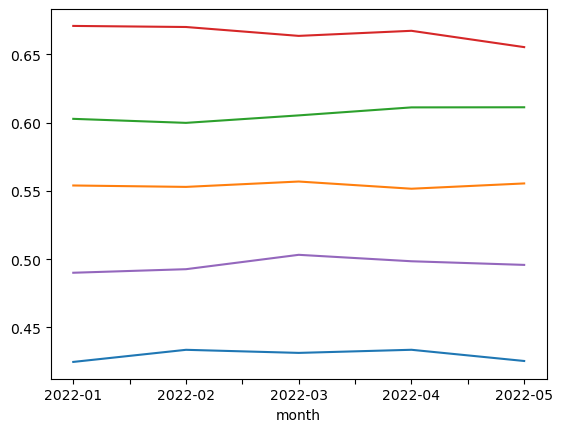

In [89]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()

In [62]:
solver = pywraplp.Solver.CreateSolver('SCIP')
x = {}
for i in range(10):
    for j in range(i + 1):
        x[i, j] = solver.BoolVar("x[{}, {}]".format(i, j))

In [63]:
x

{(0, 0): x[0, 0],
 (1, 0): x[1, 0],
 (1, 1): x[1, 1],
 (2, 0): x[2, 0],
 (2, 1): x[2, 1],
 (2, 2): x[2, 2],
 (3, 0): x[3, 0],
 (3, 1): x[3, 1],
 (3, 2): x[3, 2],
 (3, 3): x[3, 3],
 (4, 0): x[4, 0],
 (4, 1): x[4, 1],
 (4, 2): x[4, 2],
 (4, 3): x[4, 3],
 (4, 4): x[4, 4],
 (5, 0): x[5, 0],
 (5, 1): x[5, 1],
 (5, 2): x[5, 2],
 (5, 3): x[5, 3],
 (5, 4): x[5, 4],
 (5, 5): x[5, 5],
 (6, 0): x[6, 0],
 (6, 1): x[6, 1],
 (6, 2): x[6, 2],
 (6, 3): x[6, 3],
 (6, 4): x[6, 4],
 (6, 5): x[6, 5],
 (6, 6): x[6, 6],
 (7, 0): x[7, 0],
 (7, 1): x[7, 1],
 (7, 2): x[7, 2],
 (7, 3): x[7, 3],
 (7, 4): x[7, 4],
 (7, 5): x[7, 5],
 (7, 6): x[7, 6],
 (7, 7): x[7, 7],
 (8, 0): x[8, 0],
 (8, 1): x[8, 1],
 (8, 2): x[8, 2],
 (8, 3): x[8, 3],
 (8, 4): x[8, 4],
 (8, 5): x[8, 5],
 (8, 6): x[8, 6],
 (8, 7): x[8, 7],
 (8, 8): x[8, 8],
 (9, 0): x[9, 0],
 (9, 1): x[9, 1],
 (9, 2): x[9, 2],
 (9, 3): x[9, 3],
 (9, 4): x[9, 4],
 (9, 5): x[9, 5],
 (9, 6): x[9, 6],
 (9, 7): x[9, 7],
 (9, 8): x[9, 8],
 (9, 9): x[9, 9]}

# Step 1: Generate synthetic data

In [25]:
df = generate_synthetic_data()
df

,month,Y_actual,Y_predicted,ts1,ts2,ts3
0,2022-01,0.487270,0.443371,0.599299,0.513708,0.288185
1,2022-01,0.775357,0.734013,0.006464,0.496239,0.285626
2,2022-01,0.665997,0.654673,0.734608,0.023946,0.584828
3,2022-01,0.599329,0.617698,0.941474,0.174409,0.471649
4,2022-01,0.378009,0.423689,0.091422,0.625682,0.550532
...,...,...,...,...,...,...
16495,2022-05,0.667716,0.721065,0.276718,0.403522,0.783302
16496,2022-05,0.758227,0.833882,0.954285,0.554236,0.154387
16497,2022-05,0.377578,0.331467,0.214054,0.405372,0.365757
16498,2022-05,0.412207,0.557359,0.238270,0.850228,0.280112


# Step 2: Pre-bin Y_predicted using quantiles (we do not change this step)

In [27]:
df = pre_bin_predictions(df, num_bins=10)
df

,month,Y_actual,Y_predicted,ts1,ts2,ts3,bin
0,2022-01,0.487270,0.443371,0.599299,0.513708,0.288185,2
1,2022-01,0.775357,0.734013,0.006464,0.496239,0.285626,8
2,2022-01,0.665997,0.654673,0.734608,0.023946,0.584828,7
3,2022-01,0.599329,0.617698,0.941474,0.174409,0.471649,6
4,2022-01,0.378009,0.423689,0.091422,0.625682,0.550532,2
...,...,...,...,...,...,...,...
16495,2022-05,0.667716,0.721065,0.276718,0.403522,0.783302,8
16496,2022-05,0.758227,0.833882,0.954285,0.554236,0.154387,9
16497,2022-05,0.377578,0.331467,0.214054,0.405372,0.365757,0
16498,2022-05,0.412207,0.557359,0.238270,0.850228,0.280112,5


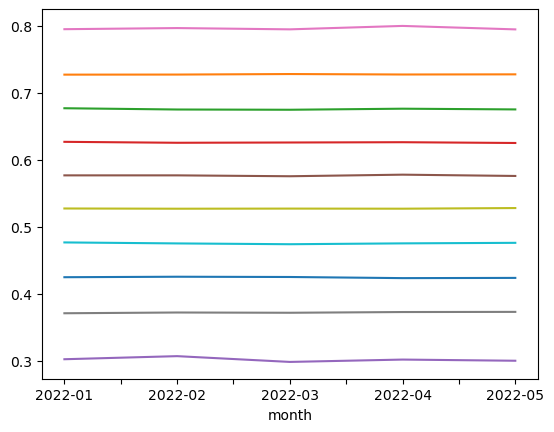

In [29]:
for i in df['bin'].unique():
    df[df['bin'] == i].groupby('month')['Y_predicted'].mean().plot()

# Step 3: Compute Euclidean distance matrix based on Y_predicted only

In [81]:
distance_matrix, unique_bins = distance_matrix_local_neighbors(df)
print(distance_matrix)
print(unique_bins)

[[0.36372149 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.3905229  0.57243329 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.4238622  0.73590898 0.37224297 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.46393489 0.88194005 0.51828807 0.30961471 0.         0.
  0.         0.         0.         0.        ]
 [0.51797842 1.02874573 0.66509589 0.45641064 0.29293454 0.
  0.         0.         0.         0.        ]
 [0.57662281 1.17371315 0.81006285 0.60137429 0.43788555 0.29185563
  0.         0.         0.         0.        ]
 [0.65530213 1.33477035 0.97111892 0.76243152 0.59891779 0.45289753
  0.30612191 0.         0.         0.        ]
 [0.77434956 1.5357203  1.17207896 0.96339635 0.79989058 0.6538471
  0.50704387 0.36218074 0.         0.        ]
 [0.95145787 1.79886791 1.4352142  1.22652935 1.06301982 0.91697715
  0.77015296 0.62520799 0.46427688 0.        ]
 [0.  

In [82]:
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9
0,0.363721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.390523,0.572433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.423862,0.735909,0.372243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.463935,0.881940,0.518288,0.309615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.517978,1.028746,0.665096,0.456411,0.292935,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.576623,1.173713,0.810063,0.601374,0.437886,0.291856,0.000000,0.000000,0.000000,0.000000
6,0.655302,1.334770,0.971119,0.762432,0.598918,0.452898,0.306122,0.000000,0.000000,0.000000
7,0.774350,1.535720,1.172079,0.963396,0.799891,0.653847,0.507044,0.362181,0.000000,0.000000
8,0.951458,1.798868,1.435214,1.226529,1.063020,0.916977,0.770153,0.625208,0.464277,0.000000
9,0.000000,1.047278,0.769076,0.640447,0.556425,0.492455,0.432025,0.382757,0.332569,0.263213


# Step 4: Compute pre-bin counts (as an array) and total observations.

In [31]:
# We assume the pre-bin labels are sorted as in unique_bins.
bin_counts_series = df["bin"].value_counts().sort_index()
bin_counts = [bin_counts_series.get(b, 0) for b in unique_bins]
total_obs = len(df)
print("Pre-bin counts:", bin_counts)
print("Total observations:", total_obs)

Pre-bin counts: [1650, 1650, 1650, 1650, 1650, 1650, 1650, 1650, 1650, 1650]
Total observations: 16500


# Step 5: Run the optimization with the minimum bin percentage constraint.

In [32]:
# Here, min_bin_pct is defined by the user (e.g., 10%).
min_bin_pct = 0.10  
optimal_bins = optimize_binning(distance_matrix, bin_counts, total_obs, min_bin_pct=min_bin_pct, min_bins=5, max_bins=6)


✅ Optimal solution found with objective value: 1.8810934968625754


# Step 6: Apply the optimal bin mapping back to the dataset.

In [33]:
df = apply_optimal_bins(df, optimal_bins)
df

,month,Y_actual,Y_predicted,ts1,ts2,ts3,bin,optimized_bin
0,2022-01,0.487270,0.443371,0.599299,0.513708,0.288185,2,9
1,2022-01,0.775357,0.734013,0.006464,0.496239,0.285626,8,8
2,2022-01,0.665997,0.654673,0.734608,0.023946,0.584828,7,7
3,2022-01,0.599329,0.617698,0.941474,0.174409,0.471649,6,6
4,2022-01,0.378009,0.423689,0.091422,0.625682,0.550532,2,9
...,...,...,...,...,...,...,...,...
16495,2022-05,0.667716,0.721065,0.276718,0.403522,0.783302,8,8
16496,2022-05,0.758227,0.833882,0.954285,0.554236,0.154387,9,9
16497,2022-05,0.377578,0.331467,0.214054,0.405372,0.365757,0,9
16498,2022-05,0.412207,0.557359,0.238270,0.850228,0.280112,5,5


# Step 7: Aggregate results by month and optimized bin.

In [34]:
aggregated_df = aggregate_by_month(df)
aggregated_df

,month,optimized_bin,Y_actual_mean,count,Y_predicted_mean
0,2022-01,5,0.578350,199,0.577022
1,2022-01,6,0.622386,198,0.627091
2,2022-01,7,0.672003,212,0.677245
3,2022-01,8,0.716470,183,0.727408
4,2022-01,9,0.485707,1208,0.483210
5,2022-02,5,0.576574,499,0.577033
6,2022-02,6,0.623868,480,0.625685
7,2022-02,7,0.676628,496,0.675350
8,2022-02,8,0.721390,487,0.727518
9,2022-02,9,0.486342,3038,0.487061


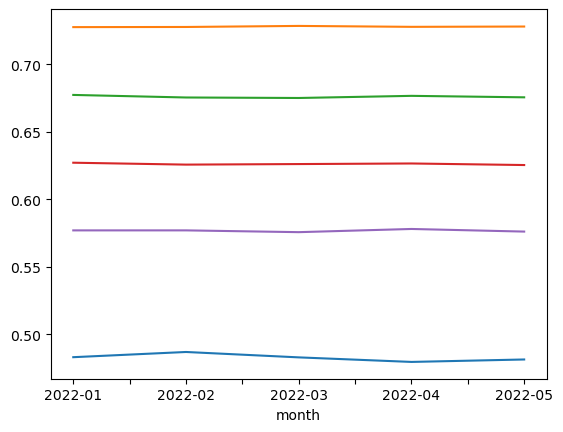

In [35]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_predicted'].mean().plot()

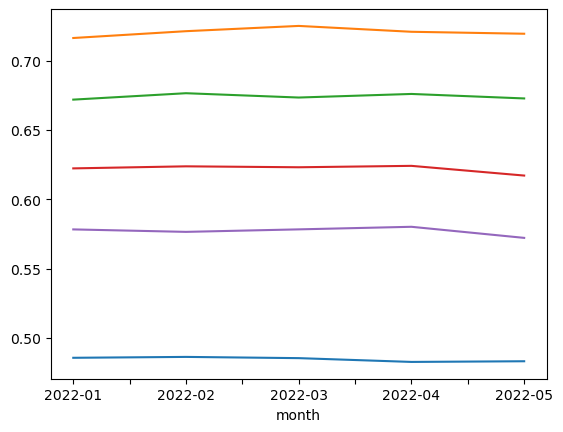

In [36]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()

# Playground

In [72]:
def compute_bin_min_percentage(df):
    """Compute the minimum percentage of total observations for each bin across all months."""
    # Compute bin counts by month
    bin_counts_by_month = df.groupby("month")["bin"].value_counts().unstack().fillna(0)
    # print(bin_counts_by_month)
    # Convert counts to percentages
    bin_percentages = bin_counts_by_month.div(bin_counts_by_month.sum(axis=1), axis=0)
    
    # Get the minimum percentage for each bin across all months
    min_bin_percentages = bin_percentages.min(axis=0).to_numpy()
    
    return min_bin_percentages
compute_bin_min_percentage(df)

bin        0    1    2    3    4    5    6    7    8    9
month                                                    
2022-01  204  201  209  178  205  188  204  199  206  206
2022-02  463  515  507  496  473  524  500  534  485  503
2022-03  310  293  318  304  303  277  317  297  276  305
2022-04  423  394  382  418  418  400  405  377  409  374
2022-05  250  247  234  254  251  261  224  243  274  262


array([0.0926    , 0.09766667, 0.0936    , 0.089     , 0.0946    ,
       0.09233333, 0.0896    , 0.09425   , 0.092     , 0.0935    ])

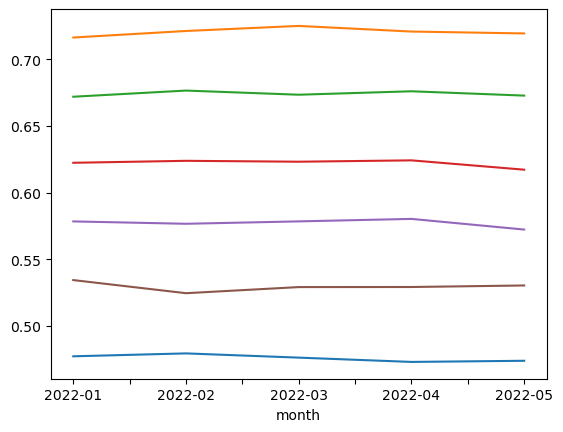

In [28]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()

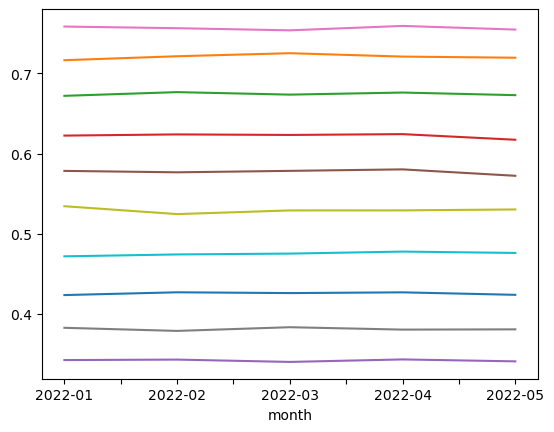

In [54]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()

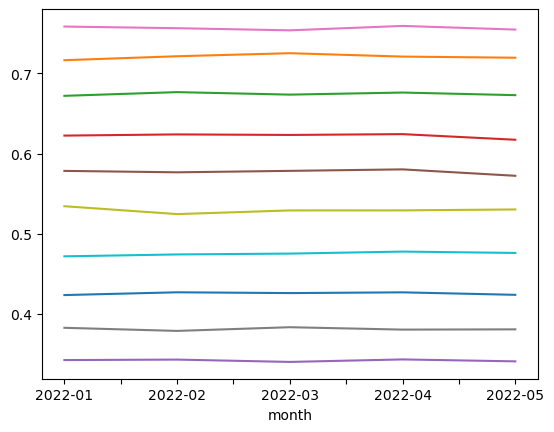

In [19]:
for i in df['bin'].unique():
    df[df['bin'] == i].groupby('month')['Y_actual'].mean().plot()

In [ ]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()

In [ ]:
import matplotlib.pyplot as plt

for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()
plt.savefig("/Users/maxwerty/Documents/PyCharm/output_opt.png")  # Saves the figure to a file
plt.show()


# Display results
print("\nOptimized binning structure:", optimal_bins)
print("\nAggregated data by month and bin:")